# 予測
- データ読み込み
- 前処理
- 特徴量作成
- 予測

In [70]:
# ライブラリ読み込み

In [59]:
import pandas as pd
import numpy as np
import argparse
import shap
import optuna
import pickle
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [3]:
# dataframe設定調整

In [4]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [5]:
# データ読み込み

In [33]:
train = pd.read_csv('../../data/rawdata/application_train.csv')

In [34]:
# 特徴量選択

In [35]:
features = ['EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'DAYS_ID_PUBLISH',
 'AMT_GOODS_PRICE',
 'DAYS_REGISTRATION',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_INCOME_TOTAL',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'HOUR_APPR_PROCESS_START',
 'TOTALAREA_MODE',
 'CODE_GENDER',
 'NAME_CONTRACT_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
'TARGET']

In [36]:
train = train.loc[:,features]

In [37]:
train.dtypes

EXT_SOURCE_1                  float64
EXT_SOURCE_3                  float64
EXT_SOURCE_2                  float64
DAYS_BIRTH                      int64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
DAYS_ID_PUBLISH                 int64
AMT_GOODS_PRICE               float64
DAYS_REGISTRATION             float64
DAYS_LAST_PHONE_CHANGE        float64
AMT_INCOME_TOTAL              float64
REGION_POPULATION_RELATIVE    float64
OWN_CAR_AGE                   float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
HOUR_APPR_PROCESS_START         int64
TOTALAREA_MODE                float64
CODE_GENDER                    object
NAME_CONTRACT_TYPE             object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
TARGET                          int64
dtype: object

In [38]:
train.isnull().sum()

EXT_SOURCE_1                  173378
EXT_SOURCE_3                   60965
EXT_SOURCE_2                     660
DAYS_BIRTH                         0
AMT_CREDIT                         0
AMT_ANNUITY                       12
DAYS_ID_PUBLISH                    0
AMT_GOODS_PRICE                  278
DAYS_REGISTRATION                  0
DAYS_LAST_PHONE_CHANGE             1
AMT_INCOME_TOTAL                   0
REGION_POPULATION_RELATIVE         0
OWN_CAR_AGE                   202929
AMT_REQ_CREDIT_BUREAU_YEAR     41519
HOUR_APPR_PROCESS_START            0
TOTALAREA_MODE                148431
CODE_GENDER                        0
NAME_CONTRACT_TYPE                 0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
TARGET                             0
dtype: int64

In [39]:
# カテゴリ変数をダミー化

In [40]:
train = pd.get_dummies(train, drop_first=True, prefix=['CODE_GENDER', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS'], prefix_sep='_')

In [41]:
# 欠損値補完

In [42]:
train.fillna(-999, inplace=True)

In [43]:
train.dtypes

EXT_SOURCE_1                                         float64
EXT_SOURCE_3                                         float64
EXT_SOURCE_2                                         float64
DAYS_BIRTH                                             int64
AMT_CREDIT                                           float64
AMT_ANNUITY                                          float64
DAYS_ID_PUBLISH                                        int64
AMT_GOODS_PRICE                                      float64
DAYS_REGISTRATION                                    float64
DAYS_LAST_PHONE_CHANGE                               float64
AMT_INCOME_TOTAL                                     float64
REGION_POPULATION_RELATIVE                           float64
OWN_CAR_AGE                                          float64
AMT_REQ_CREDIT_BUREAU_YEAR                           float64
HOUR_APPR_PROCESS_START                                int64
TOTALAREA_MODE                                       float64
TARGET                  

In [27]:
# 予測

In [44]:
target = 'TARGET'

In [45]:
X = train.drop(columns=target)

In [46]:
y = train[target]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0,
                                                   stratify=y)

In [50]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [51]:
categorical_features = [
# 'prefecture_code'
]

In [52]:
lgb_train = lgb.Dataset(X_train, y_train,
                       categorical_feature=categorical_features,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

In [53]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(
        param,                                   # 上記で設定したパラメータ
        lgb_train,                                # 使用するデータセット
        num_boost_round=1000,                     # 学習の回数
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        categorical_feature=categorical_features, # カテゴリー変数を設定
        early_stopping_rounds=50,                 # アーリーストッピング
        verbose_eval=10)                          # 学習の経過の表示(10回毎)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    
    # metrics AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    score = metrics.auc(fpr, tpr)

    # metrics F1
#     score = f1_score(y_train, y_pred)

    # MLFlow
#     with mlflow.start_run() as run:
#         mlflow.log_params(param)
#         mlflow.log_metrics({'accuracy': accuracy})
#         mlflow.lightgbm.log_model(gbm, 'model', args.conda_env)
#     print('Model logged in run {}'.format(run.info.run_uuid))
    return score

In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2021-01-06 15:50:57,535] A new study created in memory with name: no-name-a8cc8b3a-308e-4f81-98b5-c9edd6d98318


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.7449	valid's auc: 0.728462
[20]	train's auc: 0.758912	valid's auc: 0.736887
[30]	train's auc: 0.770435	valid's auc: 0.742876
[40]	train's auc: 0.78013	valid's auc: 0.745136
[50]	train's auc: 0.787989	valid's auc: 0.746449
[60]	train's auc: 0.795357	valid's auc: 0.747673
[70]	train's auc: 0.80247	valid's auc: 0.7484
[80]	train's auc: 0.808991	valid's auc: 0.74836
[90]	train's auc: 0.81571	valid's auc: 0.74804
[100]	train's auc: 0.821509	valid's auc: 0.748466
[110]	train's auc: 0.827009	valid's auc: 0.749372
[120]	train's auc: 0.832847	valid's auc: 0.749175
[130]	train's auc: 0.837641	valid's auc: 0.74902
[140]	train's auc: 0.842543	valid's auc: 0.748699
[150]	train's auc: 0.847751	valid's auc: 0.748543
[160]	train's auc: 0.852485	valid's auc: 0.748456
Early stopping, best iteration is:
[117]	train's auc: 0.830921	valid's auc: 0.749383


[I 2021-01-06 15:51:01,643] Trial 0 finished with value: 0.830920899696654 and parameters: {'lambda_l1': 0.00012477120875319887, 'lambda_l2': 0.0009722915040998078, 'num_leaves': 50, 'feature_fraction': 0.9779545546622831, 'bagging_fraction': 0.8707803965677288, 'bagging_freq': 5, 'min_child_samples': 51}. Best is trial 0 with value: 0.830920899696654.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.786395	valid's auc: 0.731946
[20]	train's auc: 0.810706	valid's auc: 0.73669
[30]	train's auc: 0.830625	valid's auc: 0.735857
[40]	train's auc: 0.853298	valid's auc: 0.735198
[50]	train's auc: 0.871057	valid's auc: 0.7331
[60]	train's auc: 0.886553	valid's auc: 0.732413
[70]	train's auc: 0.901072	valid's auc: 0.731827
Early stopping, best iteration is:
[22]	train's auc: 0.814123	valid's auc: 0.737045


[I 2021-01-06 15:51:04,169] Trial 1 finished with value: 0.8141234877240764 and parameters: {'lambda_l1': 0.05139274774108285, 'lambda_l2': 0.003137841188833759, 'num_leaves': 247, 'feature_fraction': 0.6193190844652686, 'bagging_fraction': 0.5141855978265718, 'bagging_freq': 5, 'min_child_samples': 56}. Best is trial 0 with value: 0.830920899696654.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.761878	valid's auc: 0.725025
[20]	train's auc: 0.780756	valid's auc: 0.738503
[30]	train's auc: 0.791339	valid's auc: 0.741106
[40]	train's auc: 0.801851	valid's auc: 0.743484
[50]	train's auc: 0.812329	valid's auc: 0.74485
[60]	train's auc: 0.822536	valid's auc: 0.745858
[70]	train's auc: 0.831555	valid's auc: 0.745916
[80]	train's auc: 0.840696	valid's auc: 0.746033
[90]	train's auc: 0.849131	valid's auc: 0.745966
[100]	train's auc: 0.856775	valid's auc: 0.745329
[110]	train's auc: 0.863487	valid's auc: 0.745426
[120]	train's auc: 0.870432	valid's auc: 0.745372
Early stopping, best iteration is:
[74]	train's auc: 0.83551	valid's auc: 0.746299


[I 2021-01-06 15:51:07,763] Trial 2 finished with value: 0.8355099702605444 and parameters: {'lambda_l1': 0.48534312570710253, 'lambda_l2': 1.0173232904381371e-07, 'num_leaves': 103, 'feature_fraction': 0.4152642241425711, 'bagging_fraction': 0.9189844849039741, 'bagging_freq': 7, 'min_child_samples': 80}. Best is trial 2 with value: 0.8355099702605444.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.782366	valid's auc: 0.730757
[20]	train's auc: 0.80881	valid's auc: 0.735019
[30]	train's auc: 0.83367	valid's auc: 0.739042
[40]	train's auc: 0.854705	valid's auc: 0.742393
[50]	train's auc: 0.873806	valid's auc: 0.742387
[60]	train's auc: 0.890286	valid's auc: 0.742779
[70]	train's auc: 0.904153	valid's auc: 0.742763
[80]	train's auc: 0.915912	valid's auc: 0.74139
[90]	train's auc: 0.926255	valid's auc: 0.740011
[100]	train's auc: 0.934958	valid's auc: 0.73952
[110]	train's auc: 0.943208	valid's auc: 0.738254
Early stopping, best iteration is:
[63]	train's auc: 0.894838	valid's auc: 0.742843


[I 2021-01-06 15:51:11,776] Trial 3 finished with value: 0.8948377888968566 and parameters: {'lambda_l1': 0.006406459024755466, 'lambda_l2': 0.7282795066630454, 'num_leaves': 221, 'feature_fraction': 0.9880939016615863, 'bagging_fraction': 0.8662699531337701, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 3 with value: 0.8948377888968566.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.766964	valid's auc: 0.733693
[20]	train's auc: 0.783598	valid's auc: 0.73881
[30]	train's auc: 0.799434	valid's auc: 0.74152
[40]	train's auc: 0.814974	valid's auc: 0.742636
[50]	train's auc: 0.828932	valid's auc: 0.745365
[60]	train's auc: 0.84074	valid's auc: 0.745686
[70]	train's auc: 0.852379	valid's auc: 0.745479
[80]	train's auc: 0.862062	valid's auc: 0.744407
[90]	train's auc: 0.870644	valid's auc: 0.744105
[100]	train's auc: 0.879602	valid's auc: 0.743329
Early stopping, best iteration is:
[55]	train's auc: 0.835493	valid's auc: 0.746173


[I 2021-01-06 15:51:15,320] Trial 4 finished with value: 0.8354931787293999 and parameters: {'lambda_l1': 0.00010893246183221531, 'lambda_l2': 0.004093421258701909, 'num_leaves': 111, 'feature_fraction': 0.7332577867231034, 'bagging_fraction': 0.959185454320704, 'bagging_freq': 6, 'min_child_samples': 40}. Best is trial 3 with value: 0.8948377888968566.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.752956	valid's auc: 0.731116
[20]	train's auc: 0.764864	valid's auc: 0.736119
[30]	train's auc: 0.776912	valid's auc: 0.739656
[40]	train's auc: 0.787836	valid's auc: 0.741422
[50]	train's auc: 0.797896	valid's auc: 0.742326
[60]	train's auc: 0.807136	valid's auc: 0.74265
[70]	train's auc: 0.815909	valid's auc: 0.743393
[80]	train's auc: 0.824758	valid's auc: 0.744182
[90]	train's auc: 0.832638	valid's auc: 0.744047
[100]	train's auc: 0.839788	valid's auc: 0.743801
[110]	train's auc: 0.846387	valid's auc: 0.74436
[120]	train's auc: 0.853281	valid's auc: 0.743332
[130]	train's auc: 0.859543	valid's auc: 0.743461
[140]	train's auc: 0.8641	valid's auc: 0.743287
[150]	train's auc: 0.870564	valid's auc: 0.742603
[160]	train's auc: 0.875987	valid's auc: 0.74168
Early stopping, best iteration is:
[110]	train's auc: 0.846387	valid's auc: 0.74436


[I 2021-01-06 15:51:18,900] Trial 5 finished with value: 0.8463866485522693 and parameters: {'lambda_l1': 8.953446040543195e-07, 'lambda_l2': 2.862692543156665e-08, 'num_leaves': 62, 'feature_fraction': 0.767121305133644, 'bagging_fraction': 0.5864481015953784, 'bagging_freq': 7, 'min_child_samples': 8}. Best is trial 3 with value: 0.8948377888968566.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.780095	valid's auc: 0.729962
[20]	train's auc: 0.809891	valid's auc: 0.736938
[30]	train's auc: 0.835158	valid's auc: 0.739398
[40]	train's auc: 0.857962	valid's auc: 0.739598
[50]	train's auc: 0.876878	valid's auc: 0.740372
[60]	train's auc: 0.893288	valid's auc: 0.7416
[70]	train's auc: 0.90748	valid's auc: 0.741292
[80]	train's auc: 0.919767	valid's auc: 0.740444
[90]	train's auc: 0.93098	valid's auc: 0.740047
[100]	train's auc: 0.939918	valid's auc: 0.739531
[110]	train's auc: 0.94738	valid's auc: 0.738957
Early stopping, best iteration is:
[63]	train's auc: 0.897945	valid's auc: 0.74192


[I 2021-01-06 15:51:22,539] Trial 6 finished with value: 0.8979449962264175 and parameters: {'lambda_l1': 4.297522368479032e-07, 'lambda_l2': 0.009414319281927274, 'num_leaves': 211, 'feature_fraction': 0.7993840302602022, 'bagging_fraction': 0.8408932985656359, 'bagging_freq': 5, 'min_child_samples': 42}. Best is trial 6 with value: 0.8979449962264175.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.747754	valid's auc: 0.729361
[20]	train's auc: 0.762005	valid's auc: 0.736816
[30]	train's auc: 0.77301	valid's auc: 0.742753
[40]	train's auc: 0.78311	valid's auc: 0.745001
[50]	train's auc: 0.791547	valid's auc: 0.746458
[60]	train's auc: 0.799399	valid's auc: 0.746727
[70]	train's auc: 0.806409	valid's auc: 0.74742
[80]	train's auc: 0.812742	valid's auc: 0.748608
[90]	train's auc: 0.818159	valid's auc: 0.748819
[100]	train's auc: 0.824433	valid's auc: 0.748965
[110]	train's auc: 0.829679	valid's auc: 0.749051
[120]	train's auc: 0.834936	valid's auc: 0.749139
[130]	train's auc: 0.840033	valid's auc: 0.748658
[140]	train's auc: 0.844378	valid's auc: 0.748326
[150]	train's auc: 0.849034	valid's auc: 0.748022
[160]	train's auc: 0.853744	valid's auc: 0.74742
Early stopping, best iteration is:
[117]	train's auc: 0.833546	valid's auc: 0.749183


[I 2021-01-06 15:51:26,174] Trial 7 finished with value: 0.8335462920853673 and parameters: {'lambda_l1': 0.022957112820659927, 'lambda_l2': 1.4432051727613637, 'num_leaves': 60, 'feature_fraction': 0.9846674438589562, 'bagging_fraction': 0.7465282197759902, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 6 with value: 0.8979449962264175.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.770487	valid's auc: 0.72695
[20]	train's auc: 0.79109	valid's auc: 0.735876
[30]	train's auc: 0.806241	valid's auc: 0.735701
[40]	train's auc: 0.821045	valid's auc: 0.737952
[50]	train's auc: 0.834417	valid's auc: 0.740232
[60]	train's auc: 0.848912	valid's auc: 0.740738
[70]	train's auc: 0.861306	valid's auc: 0.740328
[80]	train's auc: 0.871652	valid's auc: 0.740427
[90]	train's auc: 0.88134	valid's auc: 0.739599
[100]	train's auc: 0.890021	valid's auc: 0.738906
[110]	train's auc: 0.898673	valid's auc: 0.738169
Early stopping, best iteration is:
[64]	train's auc: 0.853967	valid's auc: 0.741065


[I 2021-01-06 15:51:29,144] Trial 8 finished with value: 0.8539665056037862 and parameters: {'lambda_l1': 1.0671211795686896e-05, 'lambda_l2': 0.03619513774786871, 'num_leaves': 141, 'feature_fraction': 0.5534298166992919, 'bagging_fraction': 0.6942524385618603, 'bagging_freq': 4, 'min_child_samples': 46}. Best is trial 6 with value: 0.8979449962264175.


Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.776897	valid's auc: 0.732277
[20]	train's auc: 0.795729	valid's auc: 0.738479
[30]	train's auc: 0.810293	valid's auc: 0.741705
[40]	train's auc: 0.823921	valid's auc: 0.742916
[50]	train's auc: 0.837603	valid's auc: 0.744055
[60]	train's auc: 0.850998	valid's auc: 0.74413
[70]	train's auc: 0.863559	valid's auc: 0.74386
[80]	train's auc: 0.87481	valid's auc: 0.744166
[90]	train's auc: 0.884826	valid's auc: 0.744082
[100]	train's auc: 0.893358	valid's auc: 0.743467
[110]	train's auc: 0.901322	valid's auc: 0.743012
Early stopping, best iteration is:
[61]	train's auc: 0.852013	valid's auc: 0.744222


[I 2021-01-06 15:51:32,266] Trial 9 finished with value: 0.8520132799532277 and parameters: {'lambda_l1': 0.5370440393215344, 'lambda_l2': 0.00022888116364250523, 'num_leaves': 156, 'feature_fraction': 0.4912886853049733, 'bagging_fraction': 0.8239979344057624, 'bagging_freq': 5, 'min_child_samples': 84}. Best is trial 6 with value: 0.8979449962264175.


Number of finished trials: 10
Best trial:
  Value: 0.8979449962264175
  Params: 
    lambda_l1: 4.297522368479032e-07
    lambda_l2: 0.009414319281927274
    num_leaves: 211
    feature_fraction: 0.7993840302602022
    bagging_fraction: 0.8408932985656359
    bagging_freq: 5
    min_child_samples: 42


In [55]:
# 二値分類
params = {
            'boosting_type': 'gbdt',        # 勾配ブースティング
            'objective': 'binary',      # 目的関数：多値分類、マルチクラス分類
            'metric': 'auc',      # 分類モデルの性能を測る指標
         }

In [56]:
params = dict(params, **study.best_params)

In [57]:
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=50,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 15888, number of negative: 180918
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3200
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432480
[LightGBM] [Info] Start training from score -2.432480
Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.780095	valid's auc: 0.729962
[20]	train's auc: 0.809891	valid's auc: 0.736938
[30]	train's auc: 0.835158	valid's auc: 0.739398
[40]	train's auc: 0.857962	valid's auc: 0.739598
[50]	train's auc: 0.876878	valid's auc: 0.740372
[60]	train's auc: 0.893288	valid's auc: 0.7416
[70]

0.8979449962264175


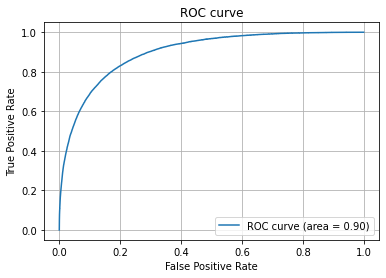

In [60]:
# # 訓練データで予測
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.7515371262212329


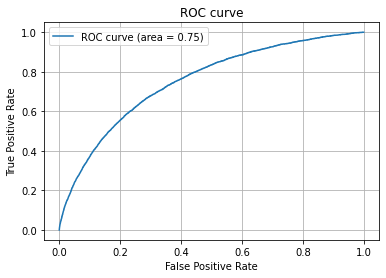

In [61]:
# # テストデータで予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)